### Zero coupon bonds

1. These bonds, as the name suggests, do not pay semi or annunal coupons to the holder.


2. These bonds are issued at a deep discount and repay the par value, at maturity. The difference between the purchase price and the par value represents the "investor's return". The payment received by the investor is equal to the principal invested plus the interest earned, compounded semiannually, at a stated yield. 


3. The disadvange of holding these bonds, is even though there are no coupon payments, the holder still has to pay income tax on the interest received at maturity.


4. Assume a bond with a face amount of \$20,000, that matures in 20 years, with a 5.5% yield, may be purchased for roughly \$6,757 ($ 20000/(1+1.05)^{20} $). At the end of the 20 years, the investor will receive \$20,000. The difference between \$20,000 and \$6,757 (or \$13,243) represents the interest that compounds automatically until the bond matures. This interest received is called "imputed interest" or "phantom interest".

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp, sqrt, pow
import pandas as pd

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


The short-rate, $r_t$, is the variable of interest in many fixed income models, that we shall use rather than considering a fixed interest rate.
  – $r_t$ is the risk-free rate that applies between periods t and t + 1
  – it is a random process but $r_t$ is known by time t.
  
Hence $r_t$ is calculated by using the multi-period binomial model. We shall return the "short rate lattice" that gives us the borrowing and lending rate in just the next time period

In [2]:
def short_rate(u, d, n, r):
    shortRateTree = np.zeros((n+1, n+1))  
    shortRateTree[0,0] = r
    for i in range(1,n+1):
        shortRateTree[0,i] = shortRateTree[0, i-1]*u
        for j in range(1,n+1):
            shortRateTree[j,i] = shortRateTree[j-1, i-1]*d
            
    return shortRateTree

In [5]:
print(short_rate(1.25, 0.9, 5, 6))
#This is a rather unrealistic situation for we can see interest rates rising upto 18% or more which does not happen in the economy, but
#for the sake of an argument

[[ 6.          7.5         9.375      11.71875    14.6484375  18.31054688]
 [ 0.          5.4         6.75        8.4375     10.546875   13.18359375]
 [ 0.          0.          4.86        6.075       7.59375     9.4921875 ]
 [ 0.          0.          0.          4.374       5.4675      6.834375  ]
 [ 0.          0.          0.          0.          3.9366      4.92075   ]
 [ 0.          0.          0.          0.          0.          3.54294   ]]


In [6]:
def bond_price(u, d, n, r, F, c = 0):
    '''F is the par value of the bond to be obtained at maturity, in other words the price at n'''
    bondPrice = np.zeros((n+1, n+1)) 
    shortRateTree = short_rate(u, d, n, r)
    for i in range(n+1):
        bondPrice[i, n] = F+c
    i = n-1
    q1 = 1/2
    q2 = 1/2
    while i+1:
        for j in range(i+1):
            bondPrice[j, i] = (q1*bondPrice[j+1, i+1] + q2*bondPrice[j, i+1])/(1+(shortRateTree[j,i]/100)) +c 
            
        i-=1
    return bondPrice, bondPrice[0,0]

In [7]:
print(bond_price(1.25, 0.9, 4, 6, 100))

(array([[ 77.21774033,  79.26800103,  83.07634728,  89.51048951,
        100.        ],
       [  0.        ,  84.43360847,  87.34985493,  92.21902017,
        100.        ],
       [  0.        ,   0.        ,  90.63619172,  94.2729201 ,
        100.        ],
       [  0.        ,   0.        ,   0.        ,  95.80930117,
        100.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        100.        ]]), 77.217740328716)


### Calculating spot rate
Basically the spot rate is calculated by finding the discount rate that makes the present value (PV) of a zero-coupon bond equal to its price. These are based on future interest rate assumptions.

So, now given the bond price calculator, we can calculate the prices of bonds at different maturities and then get the spot rates corresponding to those and plot the curve.

In [8]:
def get_bond_price_maturities(u, d, n, r, F):
    '''returns a list of bond prices of face value F with maturities 0 upto n'''
    listPrice = []
    listMaturity = []
    for i in range(n+1):
        if i==0:
            continue
        bondPrice = bond_price(u, d, i, r, F)[1]
        #print(bondPrice)
        listPrice.append(bondPrice)
        listMaturity.append(i)
    final  = pd.DataFrame([(pd.Series(listPrice)).T, (pd.Series(listMaturity)).T])
    final = final.T
    final.columns = ['bond price', 'maturity']
    return final

In [9]:
print(get_bond_price_maturities(1.25, 0.9, 4, 6, 100))

   bond price  maturity
0   94.339623       1.0
1   88.632036       2.0
2   82.912230       3.0
3   77.217740       4.0


In [10]:
def calculate_spot_rates(u, d, n, r, F):
    df = get_bond_price_maturities(u, d, n, r, F)
    spotRates = []
    for i in range(n):
        frac = F/(df['bond price'].iloc[i])
        s = np.power(frac,(1/df['maturity'].iloc[i])) - 1
        spotRates.append(s*100)
    plt.plot(spotRates)
    plt.xlabel("Time to maturity")
    plt.ylabel("Spot rates")
    plt.title("Yield curve, with zero coupon bond with principle "+str(F) + " and various maturities")   
    return spotRates

[6.000000000000005, 6.0723257728695135, 6.143887283400984, 6.214529961703263, 6.284097891471552, 6.352435419288804, 6.419388864556175, 6.484808286708765, 6.548549259993264, 6.610474602131378, 6.670456002254288, 6.72837549589731, 6.784126740592877, 6.837616054330509, 6.888763190177993, 6.937501832741799, 6.983779814835067, 7.027559064689748, 7.068815304424669, 7.107537528639285, 7.143727297616631, 7.177397882645287, 7.208573301611865, 7.237287281641636, 7.263582182644135]


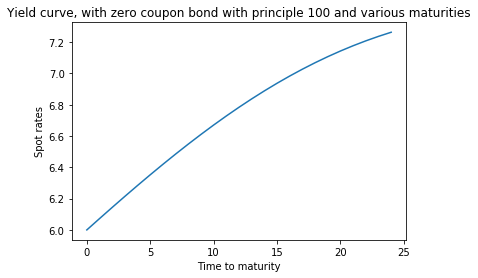

In [11]:
print(calculate_spot_rates(1.15, 0.9, 25, 6, 100))

### Yield curve

A yield curve is a graphical presentation of the term structure of interest rates, the relationship between short-term and long-term bond yields. It is plotted with bond yield on the vertical axis and the years to maturity on the horizontal axis.

#### Yield curve types:

1 . Normal yield curve
In general, long-term yields are typically higher than short-term yield due to the higher risk involved in long-term investment. Since this is the most common shape of the yield curve, it is called the normal yield curve.

Normal yield curve typically exist when an economy is neither in a recession nor there is any major risk of overheating. The yellow curve in the chart below which corresponds to 2018 is an example of the normal yield curve.

2 . Steep yield curve
A steep yield curve is the one in which the short-term yields are at normal level, but the long-term yields are higher.

A steep yield curve signals that the interest rates are expected to be increase in future. This is represented by the black line corresponding to a period in 2013.

3 . Flat yield curve
A flat curve is one in which there is no significant difference between yields on short-term and long-term debt. Since the long-term yield is lower than normal, a flat yield curve signals a slow-down in the economy and a decrease in interest rates.

When the yield curve is flat, no one would want to obtain long-term debt because they expect interest rates to fall. It is a precursor of recession.

4 . Inverted yield curve
An inverted yield curve is just opposite of the normal yield curve (therefore, it is also called abnormal yield curve). When the yield for shorter maturities is higher than the yield for longer maturities, the yield curve slopes downward and the graph looks inverted.

Yield Curves plotted during different times in history:

'source of the data - https://xplaind.com/128027/yield-curve '

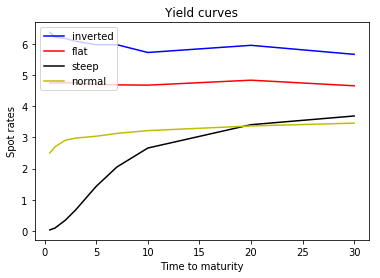

In [12]:
time_to_maturity = [0.5, 1, 2, 3, 5, 7, 10, 20, 30]
aug_31_2000 = [6.38, 6.22, 6.18, 6.09, 5.98, 5.98, 5.73, 5.96, 5.67]
mar_3_2006 = [4.75, 4.75, 4.76, 4.75, 4.71, 4.69, 4.68, 4.84, 4.66]
sep_26_2013 = [0.03, 0.09, 0.34, 0.67, 1.43, 2.05, 2.66, 3.41, 3.69]
feb_11_2018 = [2.5, 2.7, 2.91, 2.98, 3.04, 3.13, 3.22, 3.37, 3.46]
plt.plot(time_to_maturity, aug_31_2000, color = 'b', label = 'inverted')
plt.plot(time_to_maturity, mar_3_2006, color = 'r', label = 'flat')
plt.plot(time_to_maturity, sep_26_2013, color = 'k', label = 'steep')
plt.plot(time_to_maturity, feb_11_2018, color = 'y', label = 'normal')
plt.xlabel("Time to maturity")
plt.ylabel("Spot rates")
plt.title("Yield curves")
plt.legend(loc="upper left")
plt.figure(figsize=(1,1)) 

'''source of the data - https://xplaind.com/128027/yield-curve '''

### Pricing options on ZCBs:

Consider an option on a ZCB, where the option matures after N periods and the ZCB does after n. So we calibrate the lattice of the ZCB starting N, and the calculate the option prices using the prices at n.

$ O_{i,j} = (q1 * O_{i+1,j} + q2 * O_{i+1, j+1})/(1 + r_{i,j} ) $

In [27]:
def EU_call_option(u, d, n, r, F, K, N):
    '''N is the maturity of the option and K is the strike price'''
    #we calculate the short rate matrix
    shortRate = short_rate(u, d, n, r)
    #get the correponding bond price lattice
    bondPrice = bond_price(u, d, n, r, F)[0]
    q1 = 1/2
    q2 = 1/2
    optionPrice = np.zeros((N+1, N+1))
    i = N
    while i+1:
        optionPrice[i, N] = max(0, bondPrice[i, N]-K)
        i-=1
    i = N-1
    while i+1:
        for j in range(i+1):
            optionPrice[j, i] = (q1 * optionPrice[j+1,i+1] + q2 * optionPrice[j, i+1])/(1 + shortRate[j, i]/100)
        i -= 1
    print(optionPrice[0,0])
    return optionPrice

In [28]:
EU_call_option(1.25, 0.9, 4, 6, 100, 84, 2)

2.969474453180651


array([[2.97, 1.56, 0.00],
       [0.00, 4.74, 3.35],
       [0.00, 0.00, 6.64]])

In [15]:
def AM_put_option(u, d, n, r, F, K, N):
    '''N is the maturity of the option and K is the strike price'''
    #we calculate the short rate matrix
    shortRate = short_rate(u, d, n, r)
    #get the correponding bond price lattice
    bondPrice = bond_price(u, d, n, r, F)[0]
    q1 = 1/2
    q2 = 1/2
    optionPrice = np.zeros((N+1, N+1))
    i = N
    while i+1:
        optionPrice[i, N] = max(0, K-bondPrice[i, N])
        i-=1
    i = N-1
    when = []
    while i+1:
        for j in range(i+1):
            optionPrice[j, i] = (q1 * optionPrice[j+1,i+1] + q2 * optionPrice[j, i+1])/(1 + shortRate[j, i]/100)
            if_sold = max(0, K-bondPrice[j,i])
            if(if_sold>optionPrice[j,i]):
                if i not in when:
                    when.append(i)
                optionPrice[j,i] = if_sold
        i -= 1
    print(when)
    return optionPrice

In [16]:
AM_put_option(1.25, 0.9, 4, 6, 100, 88, 3)
##Turns out it’s optimal early-exercise everywhere
##– not a very realistic example.

[2, 1, 0]


array([[10.78225967,  8.73199897,  4.92365272,  0.        ],
       [ 0.        ,  3.56639153,  0.65014507,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

### Pricing Forwards on Bonds
For pricing forwards, we have to keep in mind,
1. Forward contract costs 0 at time = 0.
2. so we have $ 0 = E_0^Q[(Z^N - G_0)/B_n] $ for a forward contract with N maturity and bond with n maturity, hence,
   $ G_0 = E_0^Q[(Z^N/B_n)]/ E_0^Q[1/B_n] $
   $ E_0^Q[1/B_n] $ is the price of a ZCB with face value 1\$ and maturity n and $ E_0^Q[(Z^N/B_n)] $ is just the pric of a ZCB with maturity N and given face-value

In [17]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

In [18]:
def forward_price(u, d, n, r, F, N, c=0):
    '''c is the coupon price'''
    #get the correponding bond price lattice
    bondPrice = np.zeros((n+1, n+1)) 
    shortRateTree = short_rate(u, d, n, r)
    for i in range(n+1):
        bondPrice[i, n] = F+c
    i = n-1
    q1 = 1/2
    q2 = 1/2
    while i+1:
        for j in range(i+1):
            if i== N:
                c=0
            bondPrice[j, i] = (q1*bondPrice[j+1, i+1] + q2*bondPrice[j, i+1])/(1+(shortRateTree[j,i]/100)) +c
        i-=1
    q1 = 1/2
    q2 = 1/2
    cashAccountPrice = bond_price(u, d, N, r, 1)
    forwardPrice = bondPrice[:,:N]
    print(forwardPrice)
    print(cashAccountPrice)
    return forwardPrice[0,0]/cashAccountPrice[1]

In [19]:
forward_price(1.25, 0.9, 6, 6, 100, 4, 10)

[[79.83 79.99 81.53 85.08]
 [0.00 89.24 90.45 93.27]
 [0.00 0.00 97.67 99.85]
 [0.00 0.00 0.00 104.99]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]]
(array([[0.77, 0.79, 0.83, 0.90, 1.00],
       [0.00, 0.84, 0.87, 0.92, 1.00],
       [0.00, 0.00, 0.91, 0.94, 1.00],
       [0.00, 0.00, 0.00, 0.96, 1.00],
       [0.00, 0.00, 0.00, 0.00, 1.00]]), 0.7721774032871601)


103.37904544566828

In [20]:
bond_price(1.25, 0.9, 6, 6, 100, 10) #This is correct - just an example

(array([[124.14, 115.83, 108.98, 104.03, 101.66, 102.98, 110.00],
        [0.00, 126.14, 118.55, 112.49, 108.44, 107.19, 110.00],
        [0.00, 0.00, 126.27, 119.27, 113.83, 110.46, 110.00],
        [0.00, 0.00, 0.00, 124.57, 118.00, 112.96, 110.00],
        [0.00, 0.00, 0.00, 0.00, 121.16, 114.84, 110.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 116.24, 110.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 110.00]]), 124.13712572733934)

### Pricing futures on bonds

For futures $ F_0 = E_0^Q[(S_N)] $ where $F_0$ is the price of the futures contract and the underlying bond has a maturity of n hence $ S_N$ is the price of the bond at N time period, N is the maturity of the futures contract

In [21]:
def future_price(u, d, n, r, F, N, c=0):
    '''c is the coupon price'''
    #get the correponding bond price lattice
    bondPrice = np.zeros((n+1, n+1)) 
    shortRateTree = short_rate(u, d, n, r)
    for i in range(n+1):
        bondPrice[i, n] = F+c
    i = n-1
    q1 = 1/2
    q2 = 1/2
    while i+1:
        for j in range(i+1):
            if i== N:
                c=0
            bondPrice[j, i] = (q1*bondPrice[j+1, i+1] + q2*bondPrice[j, i+1])/(1+(shortRateTree[j,i]/100)) +c
            
        i-=1
    q1 = 1/2
    q2 = 1/2
    futurePrice = np.zeros((N+1, N+1))
    for i in range(N+1):
        futurePrice[i,N] = bondPrice[i,N]
        
    i = N-1
    while i+1:
        for j in range(i+1):
            futurePrice[j,i] = q1*futurePrice[j+1, i+1] + q2*futurePrice[j, i+1]
        i-=1
    print(futurePrice)
    return futurePrice[0,0]

In [22]:
future_price(1.25, 0.9, 6, 6, 100, 4, 10)

[[103.22 100.81 98.09 95.05 91.66]
 [0.00 105.64 103.52 101.14 98.44]
 [0.00 0.00 107.75 105.91 103.83]
 [0.00 0.00 0.00 109.58 108.00]
 [0.00 0.00 0.00 0.00 111.16]]


103.22201887112544

## Quiz questions

In [23]:
# 1.
bond_price(1.1, 0.9, 10, 5, 100)

(array([[61.62, 61.97, 62.68, 63.84, 65.56, 67.97, 71.26, 75.68, 81.58,
         89.45, 100.00],
        [0.00, 67.44, 68.07, 69.10, 70.62, 72.74, 75.62, 79.46, 84.53,
         91.20, 100.00],
        [0.00, 0.00, 72.88, 73.78, 75.10, 76.95, 79.45, 82.74, 87.06,
         92.69, 100.00],
        [0.00, 0.00, 0.00, 77.89, 79.03, 80.62, 82.76, 85.57, 89.22,
         93.93, 100.00],
        [0.00, 0.00, 0.00, 0.00, 82.42, 83.78, 85.59, 87.97, 91.05, 94.98,
         100.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 86.47, 88.01, 90.01, 92.58, 95.86,
         100.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 90.05, 91.72, 93.87, 96.58,
         100.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 93.16, 94.94, 97.19,
         100.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 95.83, 97.69,
         100.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 98.10,
         100.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
      

In [24]:
#2.
forward_price(1.1, 0.9, 10, 5, 100, 4)

[[61.62 61.97 62.68 63.84]
 [0.00 67.44 68.07 69.10]
 [0.00 0.00 72.88 73.78]
 [0.00 0.00 0.00 77.89]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]]
(array([[0.82, 0.85, 0.89, 0.94, 1.00],
       [0.00, 0.88, 0.91, 0.95, 1.00],
       [0.00, 0.00, 0.92, 0.96, 1.00],
       [0.00, 0.00, 0.00, 0.96, 1.00],
       [0.00, 0.00, 0.00, 0.00, 1.00]]), 0.8228895735604675)


74.88484493844841

In [25]:
#3.
future_price(1.1, 0.9, 10, 5, 100, 4)

[[74.82 72.72 70.47 68.09 65.56]
 [0.00 76.93 74.96 72.86 70.62]
 [0.00 0.00 78.90 77.07 75.10]
 [0.00 0.00 0.00 80.73 79.03]
 [0.00 0.00 0.00 0.00 82.42]]


74.82458063139569

In [29]:
#4.
EU_call_option(1.1, 0.9, 10, 5, 100, 80, 6)

2.3572151638290477


array([[2.36, 1.56, 0.84, 0.29, 0.00, 0.00, 0.00],
       [0.00, 3.39, 2.45, 1.49, 0.62, 0.00, 0.00],
       [0.00, 0.00, 4.65, 3.64, 2.53, 1.31, 0.00],
       [0.00, 0.00, 0.00, 6.03, 5.08, 4.00, 2.76],
       [0.00, 0.00, 0.00, 0.00, 7.42, 6.56, 5.59],
       [0.00, 0.00, 0.00, 0.00, 0.00, 8.77, 8.01],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 10.05]])